In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import torch
from datasets import load_dataset
from datasets import Audio as dsets_Audio

In [111]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RATE = 8_000  # sample rate
BATCH_SIZE = 8
print(DEVICE)

cuda


In [3]:
def simplify_audio_column(item):
    item["audio"] = item["audio"]["array"]
    return item
songs = load_dataset("lewtun/music_genres_small", split='train')
songs = songs.cast_column("audio", dsets_Audio(sampling_rate=RATE))
songs = songs.map(simplify_audio_column)
songs.set_format("torch", columns=["audio", "genre_id"], output_all_columns=True)
songs

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 1000
})

In [4]:
id2label = {}
for song in songs:
    if song['genre_id'].item() not in id2label:
        id2label[song['genre_id'].item()] = song['genre']
print(id2label)
label2id = {v: k for k, v in id2label.items()}
print(label2id)

{9: 'International', 8: 'Pop', 0: 'Electronic', 6: 'Chiptune / Glitch', 2: 'Punk', 5: 'Folk', 4: 'Hip-Hop', 1: 'Rock', 7: 'Instrumental', 3: 'Experimental'}
{'International': 9, 'Pop': 8, 'Electronic': 0, 'Chiptune / Glitch': 6, 'Punk': 2, 'Folk': 5, 'Hip-Hop': 4, 'Rock': 1, 'Instrumental': 7, 'Experimental': 3}


In [5]:
a_song = songs[30]

print(a_song['genre'])
Audio(a_song['audio'].numpy(), rate=RATE)

Rock


In [6]:
a_song

{'audio': tensor([ 1.5967e-05, -1.4751e-05,  1.3387e-05,  ..., -3.2934e-01,
         -4.8643e-01,  1.6583e-01]),
 'genre_id': tensor(1),
 'song_id': 3070,
 'genre': 'Rock'}

In [7]:
songs_split = songs.train_test_split(test_size=0.1, shuffle=True, seed=4)
songs_split

DatasetDict({
    train: Dataset({
        features: ['audio', 'song_id', 'genre_id', 'genre'],
        num_rows: 900
    })
    test: Dataset({
        features: ['audio', 'song_id', 'genre_id', 'genre'],
        num_rows: 100
    })
})

In [8]:
songs_train = songs_split["train"]
songs_val = songs_split["test"]
songs_train

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 900
})

In [112]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
def collate_fn(batch):
    # HuBERT also expects original audio lengths -- other models might want masks
    lengths = torch.tensor([len(x["audio"]) for x in batch])
    tensors = pad_sequence([x["audio"] for x in batch],
                           batch_first=True,
                           padding_value=0.)
    targets = torch.stack([x["genre_id"] for x in batch])
    return tensors, targets, lengths
    
train_loader = DataLoader(songs_train, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn)
val_loader = DataLoader(songs_val, batch_size=BATCH_SIZE, collate_fn=collate_fn)
len(train_loader), len(val_loader)

(113, 13)

In [113]:
a_batch = next(iter(train_loader))
print(a_batch[0].shape)
print(a_batch[1])
print(a_batch[2])

torch.Size([8, 240022])
tensor([2, 4, 2, 5, 7, 2, 1, 1])
tensor([239813, 239813, 239813, 239813, 240022, 240022, 239813, 240022])


In [114]:
from torchaudio.models import wav2vec2_base

class Wav2Vec2Wrapper(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.wav2vec2 = wav2vec2_base(aux_num_out=len(id2label))
        # Freeze all parameters except those in the linear layer
        for param in self.wav2vec2.feature_extractor.parameters():
            param.requires_grad = False
        for param in self.wav2vec2.encoder.parameters():
            param.requires_grad = False
            
    def forward(self, batch):
        waveforms, lengths = batch[0].to(DEVICE), batch[2].to(DEVICE)
        out, _ = self.wav2vec2(waveforms, lengths)
        # Shape [batch, chunks, classes], aggregate to [batch, classes]
        return torch.mean(out, -2)

model = Wav2Vec2Wrapper().to(DEVICE)

  0%|          | 0/30 [00:00<?, ?it/s]

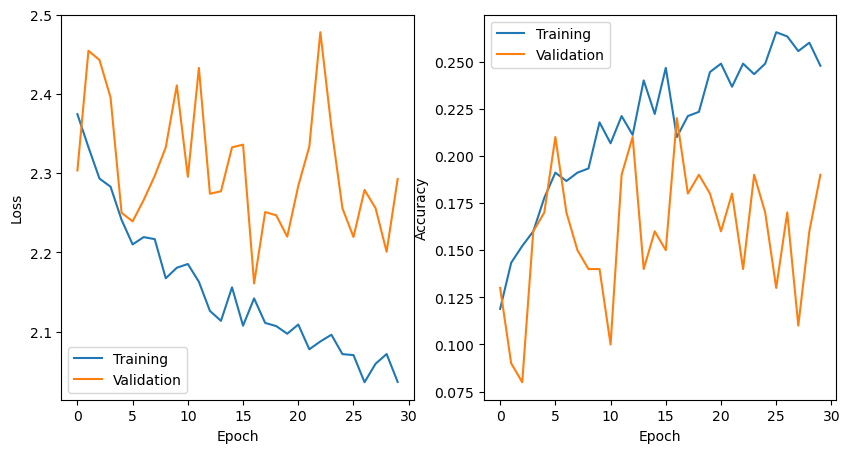

In [115]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
lr = 0.001
n_epochs = 30

def train_step(batch):
    optimizer.zero_grad()
    outputs = model(batch)
    loss = loss_fn(outputs, batch[1].to(DEVICE))
    loss.backward()
    optimizer.step()
    return outputs, loss

def val_step(batch):
    with torch.inference_mode():
        val_outputs = model(batch)
        val_loss = loss_fn(val_outputs, batch[1].to(DEVICE))
    return val_outputs, val_loss

def train_val_loop(n_epochs):
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    for i in tqdm(range(n_epochs)):
        train_loss = 0
        train_acc = 0
        model.train()
        for batch in train_loader:
            outputs, loss = train_step(batch)
            train_loss += loss.item()
            train_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        for batch in val_loader:
            outputs, loss = val_step(batch)
            val_loss += loss.item()
            val_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        
    return metrics

metrics = train_val_loop(n_epochs)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(np.arange(n_epochs), metrics["train_loss"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();
plt.subplot(122)
plt.plot(np.arange(n_epochs), metrics["train_acc"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_acc"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();

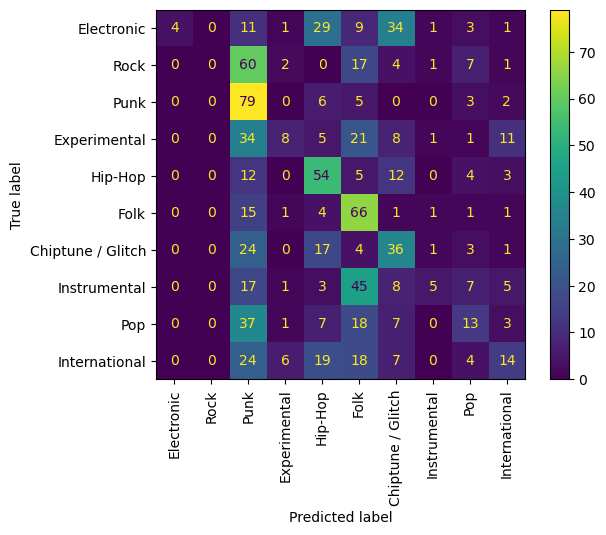

In [121]:
from sklearn.metrics import ConfusionMatrixDisplay
model.eval()
y_pred = np.zeros((len(train_loader), BATCH_SIZE))
y_true = np.zeros((len(train_loader), BATCH_SIZE))
for i, batch in enumerate(train_loader):
    with torch.inference_mode():
        logits = model(batch)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred[i, :len(preds)] = preds
    labels = batch[1].numpy()
    y_true[i, :len(labels)] = labels
y_pred = y_pred.flatten()
y_true = y_true.flatten()

labels = [id2label[i] for i in range(10)]
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels,
                                        xticks_rotation='vertical')


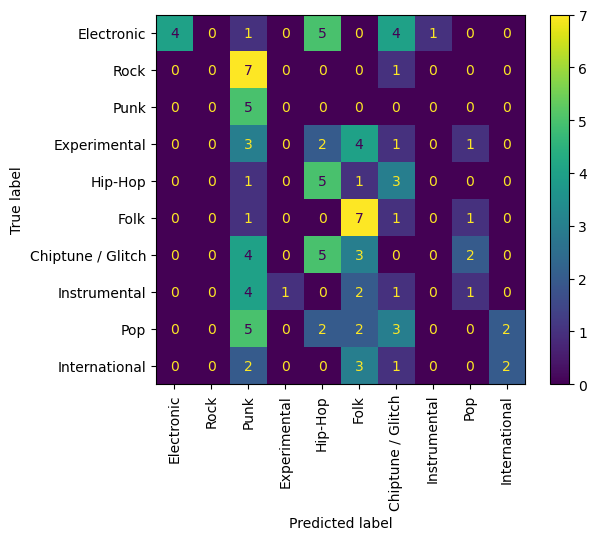

In [122]:
y_pred = np.zeros((len(val_loader), BATCH_SIZE))
y_true = np.zeros((len(val_loader), BATCH_SIZE))
for i, batch in enumerate(val_loader):
    with torch.inference_mode():
        logits = model(batch)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred[i, :len(preds)] = preds
    labels = batch[1].numpy()
    y_true[i, :len(labels)] = labels
y_pred = y_pred.flatten()
y_true = y_true.flatten()

labels = [id2label[i] for i in range(10)]
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels,
                                        xticks_rotation='vertical')